In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Drive not mounted, so nothing to flush and unmount.


In [ ]:
import pandas as pan
data_races = pan.read_csv('/content/gdrive/My Drive/csv_file/races.csv', delimiter = ",");
data_runs = pan.read_csv('/content/gdrive/My Drive/csv_file/runs.csv', delimiter = ",");
print(data_races);
print(data_runs);

FileNotFoundError: ignored

Empty DataFrame
Columns: [venue, config, surface, distance, going, race_class]
Index: []
     race_id  draw  horse_age  ... actual_weight win_odds  result
182       13    12          3  ...           120     28.0       5
846       69     1          3  ...           119     14.0      11

[2 rows x 10 columns]
        horse_age horse_country horse_type horse_rating  ... result                  
draw           1             1          1            1   ...     11    12    13    14
race_id                                                  ...                         
0             3.0          14.0        3.0         60.0  ...   12.0   8.0   9.0   6.0
1             3.0           1.0        3.0         60.0  ...    3.0   9.0  14.0  13.0
2             3.0           1.0        3.0         60.0  ...    5.0  11.0   3.0  12.0
3             3.0          14.0        5.0         60.0  ...    2.0  10.0   NaN   NaN
4             3.0          11.0        3.0         60.0  ...    7.0   4.0  11.0  12.0

[

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


Model Input ke Hidden layer <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fbe5ffed410>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 96)                10080     
_________________________________________________________________
dense_3 (Dense)              (None, 14)                1358      
Total params: 11,438
Trainable params: 11,438
Non-trainable params: 0
_________________________________________________________________
None
dataset, validation_dataset
Start training..

Epoch 1/200
11/11 [==============================] - 1s 23ms/step - loss: 3.1056 - precision: 0.0750 - val_loss: 2.9531 - val_precision: 0.1176
Epoch 2/200
11/11 [==============================] - 0s 7ms/step - loss: 2.9220 - precision: 0.0952 - val_loss: 2.8386 - val_precision: 0.1429
Epoch 3/200
11/11 [==============================] - 0s 7ms/step -

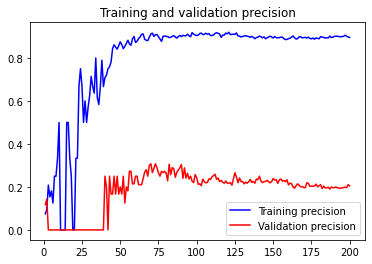

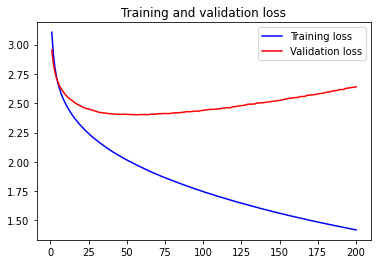

In [ ]:
#~~ (1)Process the races.csv file (Line 1-6)
# Disini kita import library yang digunakan pada machine learning
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt

#(2)ngambil dari races.csv pake 6 kolumn yang penting (Line 8-9)
races_df = pd.read_csv('/content/gdrive/My Drive/csv_file/races.csv', delimiter=",", header=0, index_col='race_id')
races_df = races_df[['venue', 'config', 'surface', 'distance', 'going', 'race_class']]

# check to see if we have NaN, then drop NaN
# (3) menghilangkan data yang fieldnya tidak berisi
print(races_df[races_df.isnull().any(axis=1)])
races_df = races_df.dropna()

# encode ordinal columns: config, going,
# (4)config, going, venue dijadikan int
config_encoder = preprocessing.OrdinalEncoder()
races_df['config'] = config_encoder.fit_transform(races_df['config'].values.reshape(-1, 1)) 
going_encoder = preprocessing.OrdinalEncoder()
races_df['going'] = going_encoder.fit_transform(races_df['going'].values.reshape(-1, 1))

# encode nominal column: venue
venue_encoder = preprocessing.LabelEncoder()
races_df['venue'] = venue_encoder.fit_transform(races_df['venue'])

#~~ (2)Process the runs.csv file
runs_df = pd.read_csv('/content/gdrive/My Drive/csv_file/runs.csv', delimiter=",", header=0)
runs_df = runs_df[['race_id', 'draw', 
                   'horse_age', 'horse_country', 'horse_type', 'horse_rating', 'declared_weight', 'actual_weight', 'win_odds', 
                   'result']] 

# check to see if we have NaN, then drop NaN
#(5) delete data yang masih null
print(runs_df[runs_df.isnull().any(axis=1)])
runs_df = runs_df.dropna()

#(6) Delete dimana pertandingan terdapat lebih dari 14 kuda
# not sure why, but we got some strange draw in the dataset. Maximum shall be 14
strange_draw_index = runs_df[runs_df['draw'] > 14].index
# delete these row indexes from dataFrame
runs_df = runs_df.drop(strange_draw_index)

#(7) Di jadikan int horse_country, horse_type
# encode nominal columns: horse_country, horse_type
horse_country_encoder = preprocessing.LabelEncoder()
runs_df['horse_country'] = horse_country_encoder.fit_transform(runs_df['horse_country'])
horse_type_encoder = preprocessing.LabelEncoder()
runs_df['horse_type'] = horse_type_encoder.fit_transform(runs_df['horse_type'])

#~~(3)
#(8)
def group_horse_and_result(element):
    if element[0] == 'result':
        return 100 + element[1] # to make sure results are put near the end
    else:
        return element[1]   

runs_df = runs_df.pivot(index='race_id', columns='draw', values=runs_df.columns[2:])
rearranged_columns = sorted(list(runs_df.columns.values), key=group_horse_and_result)
runs_df = runs_df[rearranged_columns]
print(runs_df.head())

# quite some NaNs appreared in the dataframe, reason is some races didnt have full 14 horses participating
# fill with 0
runs_df = runs_df.fillna(0)

#~~(4)Prepare the train and test datasets
data = races_df.join(runs_df, on='race_id', how='right')
X = data[data.columns[:-14]]
print ("data x " , X)
ss = preprocessing.StandardScaler()
X = pd.DataFrame(ss.fit_transform(X),columns = X.columns)

y = data[data.columns[-14:]].applymap(lambda x: 1.0 if 0.5 < x < 1.5 else 0.0) 

print(X.shape)
print(y.shape)

# split data into train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

#~~(5)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(96, activation='relu', input_shape=(104,)),
    tf.keras.layers.Dense(14, activation='softmax')
])
print ("Model Input ke Hidden layer", model)
model.compile(optimizer=tf.keras.optimizers.Adam(5e-04),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Precision(name='precision')])
print(model.summary())

#~~(6) Train the network and plot the performance
dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
train_dataset = dataset.shuffle(len(X_train)).batch(500)
dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
validation_dataset = dataset.shuffle(len(X_test)).batch(500)
print ("dataset, validation_dataset")

print("Start training..\n")
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset)
print("Done.")

precision = history.history['precision']
val_precision = history.history['val_precision']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(precision) + 1)
print ("history : ")
print(history)
plt.plot(epochs, precision, 'b', label='Training precision')
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')

#cara menemukan hasil terbesar di list python
print("list['val_precision'] maxed value", max(history.history['val_precision'])) #setelah data berhasil di train, seberapa x/10 kemenangan, #best prediciton scenario
print("list['precision'] maxed value", max(history.history['precision'])) #dari val_precision seberapa accurate
plt.legend()
plt.show()

